In [1]:
from IPython.display import display, Markdown
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile as zf
import glob
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# Importando o dataset

train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=transforms.ToTensor()
)

**Exemplos de Imagens do Dataset:**

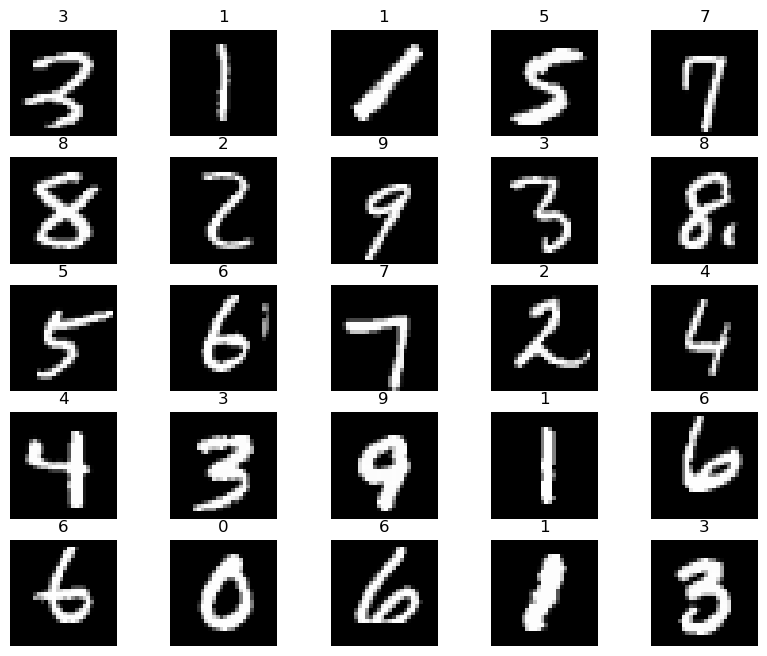

In [3]:
# Exibindo algumas imagens do dataset de treinamento

display(Markdown("**Exemplos de Imagens do Dataset:**"))

figure = plt.figure(figsize=(10,8))
cols,rows = 5,5

for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')

plt.show()

In [4]:
# Verificando o shape do dataset de treinamento (quantidade de imagens, altura das imagens, largura das imagens)

display(Markdown("**Shape do Dataset de Treinamento:**"))

train_data.data.shape

**Shape do Dataset de Treinamento:**

torch.Size([60000, 28, 28])

In [5]:
# Verificando o shape do dataset de teste (quantidade de imagens, altura das imagens, largura das imagens)

display(Markdown("**Shape do Dataset de Teste:**"))

test_data.data.shape

**Shape do Dataset de Teste:**

torch.Size([10000, 28, 28])

In [6]:
# Definindo alguns hiperparâmetros do modelo

batch_size=100
lr=0.01 
epochs=5

In [7]:
# Criando os dataloaders de treinamento e de teste

display(Markdown("**Quantidade de DataLoaders:**"))

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)


print("Dataloaders de treinamento: {} \nDataloaders de teste: {}".format(len(train_loader), len(test_loader)))

**Quantidade de DataLoaders:**

Dataloaders de treinamento: 600 
Dataloaders de teste: 100


In [8]:
# Criação da Rede Convolucional

class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        kernel_size=4
        stride=3
        channels=1
        
        self.bn1 = nn.BatchNorm2d(channels)
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(channels, 4, kernel_size=kernel_size, stride=stride),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=kernel_size, stride=stride),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
            
        
        self.ln1 = nn.Linear(16,10)
        self.rl1 = nn.ReLU()
        
    def forward(self, x):
        out = self.bn1(x)
        out = self.layer1(out)
        #print("shape1: ",out.shape)
        out = self.layer2(out)
        #print("shape2: ",out.shape)
        out  =out.view(out.size(0), -1)
        #print("shape3: ",out.shape)
        out = self.ln1(out)
        out = self.rl1(out)

        return(out)

In [9]:
# Instanciação do modelo e preparação para treinamento

display(Markdown("**Estrutura da CNN:**"))

model = Cnn()
model.train()

**Estrutura da CNN:**

Cnn(
  (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(3, 3))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(4, 16, kernel_size=(4, 4), stride=(3, 3))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (ln1): Linear(in_features=16, out_features=10, bias=True)
  (rl1): ReLU()
)

In [10]:
# Definição do otimizador e do critério de otimização

optimizer = optim.Adam(model.parameters(), lr)
criterion = nn.CrossEntropyLoss()

In [11]:
# Treinamento do modelo

display(Markdown("**Treinamento do Modelo:**"))

for epoch in range(epochs):
    epoch_loss=0
    epoch_accuracy=0
    
    for data, label in train_loader:
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print("Epoch: {}, Train Accuracy: {}, Train Loss: {}".format(epoch+1, epoch_accuracy, epoch_loss))

**Treinamento do Modelo:**

Epoch: 1, Train Accuracy: 0.7346166968345642, Train Loss: 0.903863251209259
Epoch: 2, Train Accuracy: 0.8112329244613647, Train Loss: 0.7314556241035461
Epoch: 3, Train Accuracy: 0.8199328780174255, Train Loss: 0.708088755607605
Epoch: 4, Train Accuracy: 0.8229160904884338, Train Loss: 0.697783350944519
Epoch: 5, Train Accuracy: 0.8270824551582336, Train Loss: 0.6865429282188416


In [12]:
# Preparação do modelo para o processo de avaliação

display(Markdown("**Estrutura da CNN:**"))

model.eval()

**Estrutura da CNN:**

Cnn(
  (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(3, 3))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(4, 16, kernel_size=(4, 4), stride=(3, 3))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (ln1): Linear(in_features=16, out_features=10, bias=True)
  (rl1): ReLU()
)

In [13]:
# Avaliação do modelo para os dados de teste

display(Markdown("**Avaliação do Modelo para dados de Teste**"))

accuracy_test=0
loss_test=0

for data, label in test_loader:
    output  = model(data)
    loss = criterion(output, label)
    
    acc = (output.argmax(dim=1) == label).float().mean()
    accuracy_test += acc/len(test_loader)
    loss_test += loss/len(test_loader)
    
print("Accuracy Test: {} \nLoss Test: {}".format(accuracy_test, loss_test))

**Avaliação do Modelo para dados de Teste**

Accuracy Test: 0.8274999856948853 
Loss Test: 0.6706659197807312
